In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드
data = pd.read_csv('data/All_not_null/55285839-9b78-48d8-9f4e-573190ace016_data.csv')

# 2. null값 처리
data = data.dropna() 

# 데이터의 시간 정보를 사용하여 훈련과 테스트 데이터 나누기
# 여기서는 'created_at' 컬럼을 기준으로 시계열을 정렬
data['created_at'] = pd.to_datetime(data['created_at'], unit='s')
data = data.sort_values(by='created_at')
target = data['imbalance_health']

# 3. 필요한 열 선택 (라벨 및 불필요한 열 제외)
data = data.drop(columns=['asset_id', 'created_at', 'created_at_datetime', 'temperature', 'looseness_health', 'time','misalignment_health', 'asset_health', 'bearing_health', 'imbalance_health'])
data = data.loc[:,['vel_crest_factor_x', 'rms_x', 'vel_kurtosis_y','vel_kurtosis_z', 'vel_peak_z','skewness_y','crest_factor_y','vel_skewness_x','vel_rms_xyz','peak_y','peak_x']]
scaler = MinMaxScaler()
X_scaled_d = scaler.fit_transform(data)

In [2]:
# 4. t-SNE를 통한 데이터 차원 축소
tsne = TSNE(n_components=2,
            verbose=1,
            random_state=42)
tsne_result = tsne.fit_transform(X_scaled_d)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2515 samples in 0.004s...
[t-SNE] Computed neighbors for 2515 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2515
[t-SNE] Computed conditional probabilities for sample 2000 / 2515
[t-SNE] Computed conditional probabilities for sample 2515 / 2515
[t-SNE] Mean sigma: 0.038431
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.412964
[t-SNE] KL divergence after 1000 iterations: 1.307375


In [3]:
# 결과를 DataFrame 형식으로 변경
tsne_result_df = pd.DataFrame(tsne_result, columns=['x', 'y'])
tsne_result_df['label'] = target
tsne_result_df['label'] = tsne_result_df['label'].apply(lambda x: 1 if x > 0.99 else 0)

<Axes: xlabel='x', ylabel='y'>

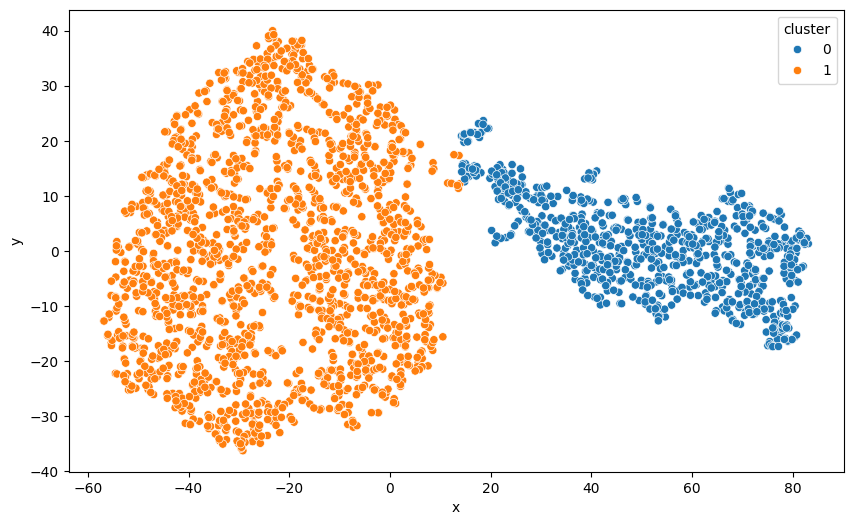

In [4]:
# 5. k-means를 통한 군집화
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(tsne_result_df)

# 결과를 DataFrame에 추가
tsne_result_df['cluster'] = clusters

# 군집 결과 시각화
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=tsne_result_df, 
    x='x', 
    y='y', 
    hue='cluster',  # 군집 결과에 따라 색상 구분
)

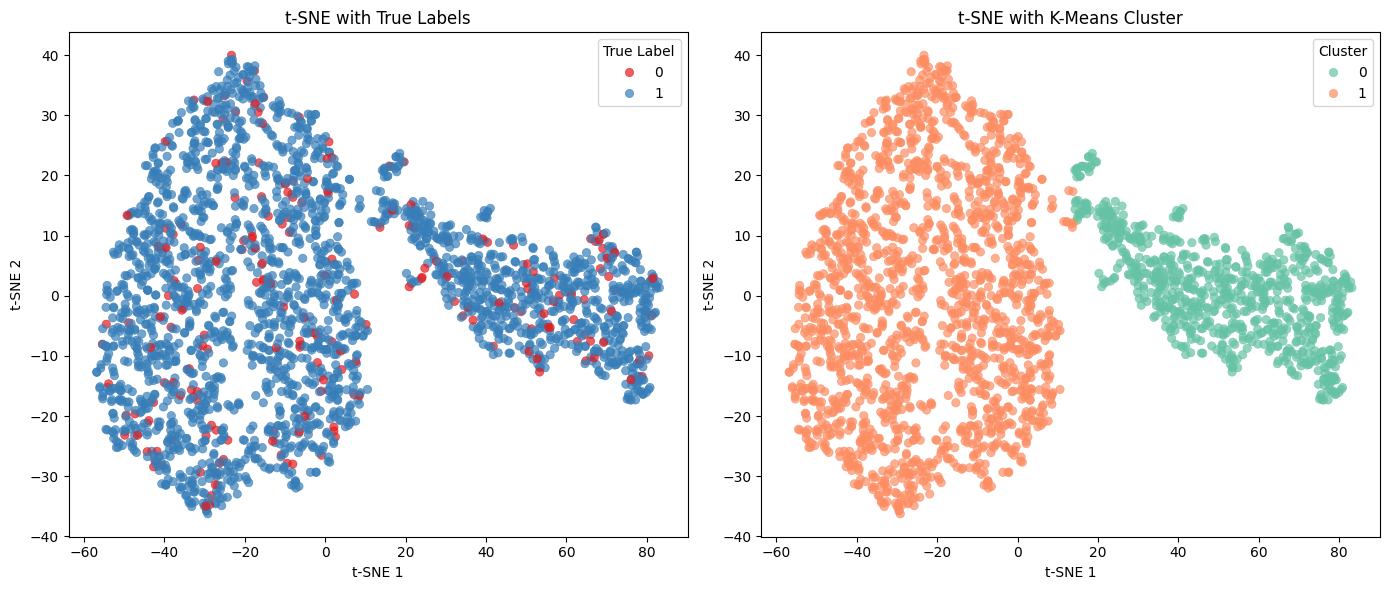

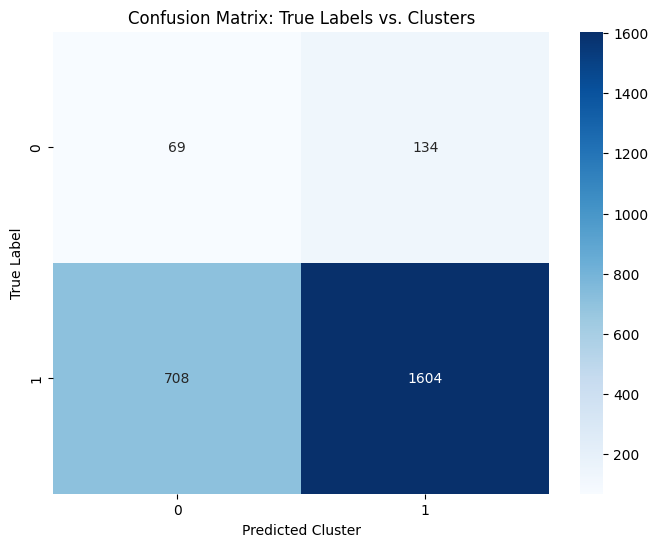

In [5]:
# 클러스터와 실제 라벨 비교 시각화
plt.figure(figsize=(14, 6))

# 실제 라벨을 사용한 시각화
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=tsne_result_df,
    x='x',
    y='y',
    hue='label',  # 실제 라벨에 따라 색상 구분
    palette='Set1',
    alpha=0.7,
    edgecolor=None
)
plt.title('t-SNE with True Labels')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='True Label')

# 클러스터 결과를 사용한 시각화
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=tsne_result_df,
    x='x',
    y='y',
    hue='cluster',  # 클러스터 결과에 따라 색상 구분
    palette='Set2',
    alpha=0.7,
    edgecolor=None
)
plt.title('t-SNE with K-Means Cluster')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()

# 혼동 행렬을 통한 클러스터와 실제 라벨의 대응 관계 평가
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 혼동 행렬 계산
conf_matrix = confusion_matrix(tsne_result_df['label'], tsne_result_df['cluster'])

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: True Labels vs. Clusters')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.show()
